In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [181]:
#Orchestative Exploration Algorithm
# 0 indexing for arms
t = 1
T = 10000
N = 7                                      # Number of plays per round
K = 9                                      # Number of arms
Yt  = []                                    # Arms deserving UE
St = np.arange(0, N, dtype=int)             # set of Empirically optimal arms for IE
St_bar = []
Lt = N-1                                    # Empirically least favoured arm in St (least mean arm in St)
Lt2 = N-1
mu_hat_t = np.zeros(K, dtype=float)           # Estimate of mean of arm rewards at time t when PIE used
v_hat_t = np.zeros(K, dtype=float)            # Estimate of mean of arm rewards at time t when PUE used
ut = np.zeros(K, dtype=float)                 # 
tau_hat_t = np.ones(K, dtype=int)           # No. of times such that assigned pulls < capacity (lower limit)
i_hat_t = np.ones(K, dtype=int)             # No. of times such that assigned pulls > capacity |(upper limit)
pulls_t = tau_hat_t + i_hat_t               # Total no. of pulls till time t
m_lt = np.ones(K, dtype=int)                # Lower estimate of capacity value
m_ut = N*np.ones(K, dtype=int)              # Upper estimate of capacity value
delta = 2/T
M = 8
reward_total = np.zeros(K, dtype=float)       # Total reward per arm
regret_step1 = np.zeros(T, dtype=float)
regret_step2 = np.zeros(T, dtype=float)
capacity_error = np.zeros(T, dtype=float) 
reward_step_t = np.zeros(K, dtype = float)
K_UCB = np.zeros(N, dtype= float)
# Nk_t        ## Number of times an arm is pulled till time t

In [182]:
def Oracle(mu_hat, mt):
    idx_descending = np.argsort(mu_hat)[::-1]           # Here we are sorting the indices in descending order of means

    # We now need to check the capacity for the indices obtained above
    at = np.zeros(K, dtype=int)
    play_rem = N
    for i in (idx_descending):
        at[i] = min(mt[i], play_rem)
        play_rem = max(play_rem - at[i], 0)
        if (play_rem == 0):
            break

    return at

In [183]:
class theOracle:
    def __init__(self, K):
        self.K = K
        self.mu = np.ones(self.K, dtype=float)
        self.var = 0.5
        self.m = np.ones(self.K, dtype=int)

        self.mu = [5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1]
        self.m = [2, 4, 3, 3, 2, 1, 1, 1, 1]

    def play(self, at):
        # This function has access to the actual means of the arms and outputs according to that
        # That access should not be given to any other function
        # This function should be part of some class which has all the data
        reward = np.zeros(K, dtype=float)
        for k in range (K):
            reward[k] = abs(np.sum(np.random.normal(self.mu[k], self.var, min(at[k], self.m[k]))))

        return reward
    
    def optimalRewards(self):
        at_opt = Oracle(self.mu, self.m)
        reward_opt = self.play(at_opt)
        return reward_opt

    def regret(self, rewards_act):
        f_opt = np.sum(self.optimalRewards())
        # print("Opt", f_opt)
        f_act = np.sum(rewards_act)
        # print("Actual", f_act)
        regret = f_opt - f_act
        return regret
    
    def capacity_estimate_error(self, m_lt):
        return np.sum(abs(m_lt - self.m))

In [184]:
def ut_update(tau_hat_t, mu_hat_t, t):
    ut = mu_hat_t + 2*np.sqrt((np.log(t)+4*np.log(np.log(t)+1))/tau_hat_t)
    return ut

In [185]:
def PIE(mu_hat_t, m_lt, tau_hat_t, reward_total, ut, p):
    ut = ut_update(tau_hat_t, mu_hat_t, t)
    at_IE = Oracle(mu_hat_t, m_lt)
    not_zero = np.count_nonzero(at_IE)
    St1 = np.nonzero(at_IE)
    St = np.asarray(St1)
    St.resize(not_zero)
    zero = K - not_zero
    St_bar = np.where(at_IE == 0)[0]
    St_bar.resize(zero)

    idx_ascending = np.argsort(mu_hat_t)                # Is there some better way
    for i in idx_ascending:
        if (np.isin(i, St)):
            Lt = i
            break
    
    Et = []
    for k in St_bar:
        if (ut[k] >= mu_hat_t[Lt]):
            Et.append(k)

    if (len(Et) > 0):
        toss = np.random.choice([0, 1], p=[1-p, p])
        if (toss):
            l = np.random.choice(Et, size=1)
            at_IE[Lt] -= 1
            at_IE[l] = 1

    reward = theGame.play(at_IE)
    reward_step_t = reward.copy()
    reward_total += reward

    ## Update values
    # Here no. of plays of an arm is equal to what we assigned
    for k in range (K):
        mu_hat_t [k] = (mu_hat_t[k]*tau_hat_t[k] + reward[k])/(tau_hat_t[k] + at_IE[k])             # given that rewards from function play are total reward of one particular arm

    ## u_t
    # ut = ut_update(tau_hat_t, mu_hat_t, t)

    tau_hat_t += at_IE                                                               # Is notation okay?
    return reward_step_t

In [186]:
def PIE2(mu_hat_t, m_lt, tau_hat_t, reward_total, ut, p):
    Lt2 = N-1
    ut = ut_update(tau_hat_t, mu_hat_t, t)
    at_IE = Oracle(mu_hat_t, m_lt)
    not_zero = np.count_nonzero(at_IE)
    St1 = np.nonzero(at_IE)
    St = np.asarray(St1)
    St.resize(not_zero)
    zero = K - not_zero
    St_bar = np.where(at_IE == 0)[0]
    St_bar.resize(zero)

    idx_ascending = np.argsort(mu_hat_t)                # Is there some better way
    for i in idx_ascending:
        ind = 0
        if (np.isin(i, St) and ind == 0):
            Lt = i
            ind += 1
        elif (np.isin(i, St) and ind == 1):
            Lt2 = i
            break
    
    Et = []
    for k in St_bar:
        if (ut[k] >= mu_hat_t[Lt]):
            Et.append(k)

    if (len(Et) > 0):
        toss = np.random.choice([0, 1], p=[1-p, p])
        if (toss):
            l = np.random.choice(Et, size=2)
            at_IE[Lt] -= 1
            # at_IE[Lt2] -= 1
            at_IE[l[0]] = 1
            at_IE[l[1]] = 1

    reward = theGame.play(at_IE)
    reward_step_t = reward.copy()
    reward_total += reward

    ## Update values
    # Here no. of plays of an arm is equal to what we assigned
    for k in range (K):
        mu_hat_t [k] = (mu_hat_t[k]*tau_hat_t[k] + reward[k])/(tau_hat_t[k] + at_IE[k])             # given that rewards from function play are total reward of one particular arm

    ## u_t
    # ut = ut_update(tau_hat_t, mu_hat_t, t)

    tau_hat_t += at_IE                                                               # Is notation okay?
    return reward_step_t

In [187]:
def PUE(mu_hat_t, Yt, M, i_hat_t, reward_total, v_hat_t):
    mu_hat_t_prime = mu_hat_t.copy()
    for k in Yt:
        mu_hat_t_prime[k] += M
    at_UE = Oracle(mu_hat_t_prime, m_ut)
    # print(mu_hat_t_prime)
    reward = theGame.play(at_UE)
    reward_step_t = reward.copy()
    reward_total += reward

    ## Update the values
    # Here number of plays of each arm is equal to its capacity, basically mu_t, here we will consider the average by considering the increase in no. of pulls by 1
    for k in range (K):
        v_hat_t[k] = (v_hat_t[k]*i_hat_t[k] + reward[k])/(i_hat_t[k] + 1)
    i_hat_t += at_UE                                        # Should increase be equal to this? as we are not actually playing at_UE arms
    return reward_step_t
    

In [188]:
def phi(x, delta):
    return np.sqrt((1+1/x)*np.log(2*np.sqrt(x+1)/delta)/(2*x))

In [189]:
if __name__=="__main__":
    theGame = theOracle(K)
    while (t < T):
        if t % 2 == 1 or len(Yt) == 0:
            reward_step_t =  PIE(mu_hat_t, m_lt, tau_hat_t, reward_total, ut, 0.5)
        else:
            reward_step_t = PUE(mu_hat_t, Yt, M, i_hat_t, reward_total, v_hat_t)
        ## update mlt and mut
        for k in range(K):
            if(t > 1):
                m_lt[k] = max(np.ceil(v_hat_t[k]/(mu_hat_t[k] + phi(tau_hat_t[k], delta) + phi(i_hat_t[k], delta))), 1, m_lt[k])
                m_ut[k] = max(min(abs(np.floor((v_hat_t[k])/(mu_hat_t[k] - phi(tau_hat_t[k], delta)) - phi(i_hat_t[k], delta))), N, m_ut[k]), theGame.m[k])

        Yt = []
        for k in St:
            if (k != Lt):
                if (m_lt[k] != m_ut[k]):
                    Yt.append(k)
        regret_step1[t] = theGame.regret(reward_step_t) + regret_step1[max(0, t-1)]
        capacity_error[t] = theGame.capacity_estimate_error(m_lt) + capacity_error[max(0, t-1)]
        t += 1

    
    t = 1
    T = 10000
    N = 7                                      # Number of plays per round
    K = 9                                      # Number of arms
    Yt  = []                                    # Arms deserving UE
    St = np.arange(0, N, dtype=int)             # set of Empirically optimal arms for IE
    St_bar = []
    Lt = N-1                                    # Empirically least favoured arm in St (least mean arm in St)
    mu_hat_t = np.zeros(K, dtype=float)           # Estimate of mean of arm rewards at time t when PIE used
    v_hat_t = np.zeros(K, dtype=float)            # Estimate of mean of arm rewards at time t when PUE used
    ut = np.zeros(K, dtype=float)                 # 
    tau_hat_t = np.ones(K, dtype=int)           # No. of times such that assigned pulls < capacity (lower limit)
    i_hat_t = np.ones(K, dtype=int)             # No. of times such that assigned pulls > capacity (upper limit)
    pulls_t = tau_hat_t + i_hat_t               # Total no. of pulls till time t
    m_lt = np.ones(K, dtype=int)                # Lower estimate of capacity value
    m_ut = N*np.ones(K, dtype=int)              # Upper estimate of capacity value
    delta = 2/T
    M = 8
    reward_total = np.zeros(K, dtype=float)       # Total reward per arm
    # regret_step1 = np.zeros(T, dtype=float)
    regret_step2 = np.zeros(T, dtype=float)
    capacity_error2 = np.zeros(T, dtype=float) 
    reward_step_t = np.zeros(K, dtype = float)


    theGame1 = theOracle(K)
    while (t < T):
        if t % 2 == 1 or len(Yt) == 0:
            reward_step_t =  PIE(mu_hat_t, m_lt, tau_hat_t, reward_total, ut, 0.8)
        else:
            reward_step_t = PUE(mu_hat_t, Yt, M, i_hat_t, reward_total, v_hat_t)
        ## update mlt and mut
        for k in range(K):
            if(t > 1):
                m_lt[k] = max(np.ceil(v_hat_t[k]/(mu_hat_t[k] + phi(tau_hat_t[k], delta) + phi(i_hat_t[k], delta))), 1, m_lt[k])
                m_ut[k] = max(min(abs(np.floor((v_hat_t[k])/(mu_hat_t[k] - phi(tau_hat_t[k], delta)) - phi(i_hat_t[k], delta))), N, m_ut[k]), theGame1.m[k])

        Yt = []
        for k in St:
            if (k != Lt):
                if (m_lt[k] != m_ut[k]):
                    Yt.append(k)
        regret_step2[t] = theGame1.regret(reward_step_t) + regret_step2[max(0, t-1)]
        capacity_error2[t] = theGame1.capacity_estimate_error(m_lt) + capacity_error2[max(0, t-1)]
        t += 1

    t = 1
    T = 10000
    N = 7                                      # Number of plays per round
    K = 9                                      # Number of arms
    Yt  = []                                    # Arms deserving UE
    St = np.arange(0, N, dtype=int)             # set of Empirically optimal arms for IE
    St_bar = []
    Lt = N-1                                    # Empirically least favoured arm in St (least mean arm in St)
    Lt2 = N-1
    mu_hat_t = np.zeros(K, dtype=float)           # Estimate of mean of arm rewards at time t when PIE used
    v_hat_t = np.zeros(K, dtype=float)            # Estimate of mean of arm rewards at time t when PUE used
    ut = np.zeros(K, dtype=float)                 # 
    tau_hat_t = np.ones(K, dtype=int)           # No. of times such that assigned pulls < capacity (lower limit)
    i_hat_t = np.ones(K, dtype=int)             # No. of times such that assigned pulls > capacity (upper limit)
    pulls_t = tau_hat_t + i_hat_t               # Total no. of pulls till time t
    m_lt = np.ones(K, dtype=int)                # Lower estimate of capacity value
    m_ut = N*np.ones(K, dtype=int)              # Upper estimate of capacity value
    delta = 2/T
    M = 8
    reward_total = np.zeros(K, dtype=float)       # Total reward per arm
    # regret_step1 = np.zeros(T, dtype=float)
    regret_step3 = np.zeros(T, dtype=float)
    capacity_error3 = np.zeros(T, dtype=float) 
    reward_step_t = np.zeros(K, dtype = float)


    theGame2 = theOracle(K)
    while (t < T):
        if t % 2 == 1 or len(Yt) == 0:
            reward_step_t =  PIE2(mu_hat_t, m_lt, tau_hat_t, reward_total, ut, 0.8)
        else:
            reward_step_t = PUE(mu_hat_t, Yt, M, i_hat_t, reward_total, v_hat_t)
        ## update mlt and mut
        for k in range(K):
            if(t > 1):
                m_lt[k] = max(np.ceil(v_hat_t[k]/(mu_hat_t[k] + phi(tau_hat_t[k], delta) + phi(i_hat_t[k], delta))), 1, m_lt[k])
                m_ut[k] = max(min(abs(np.floor((v_hat_t[k])/(mu_hat_t[k] - phi(tau_hat_t[k], delta)) - phi(i_hat_t[k], delta))), N, m_ut[k]), theGame2.m[k])

        Yt = []
        for k in St:
            if (k != Lt):
                if (m_lt[k] != m_ut[k]):
                    Yt.append(k)
        regret_step3[t] = theGame2.regret(reward_step_t) + regret_step3[max(0, t-1)]
        capacity_error3[t] = theGame2.capacity_estimate_error(m_lt) + capacity_error3[max(0, t-1)]
        t += 1

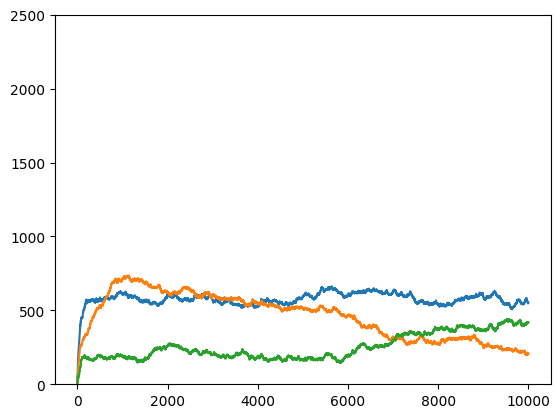

In [190]:
plt.plot(regret_step1)
plt.plot(regret_step2)
plt.plot(regret_step3)
plt.ylim(0, 2500)
plt.show()

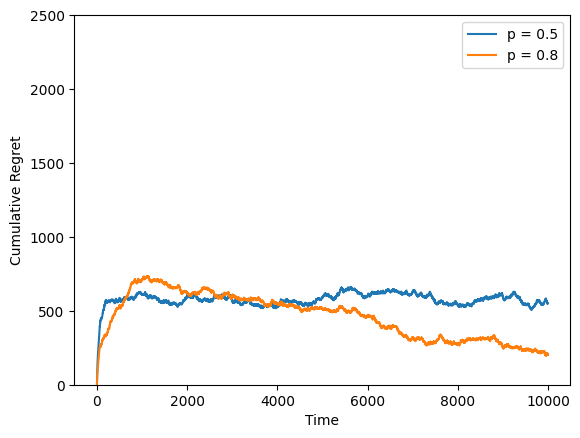

In [207]:
plt.plot(regret_step1, label = "p = 0.5")
plt.plot(regret_step2, label = "p = 0.8")
# plt.plot(regret_step3, label = "More exploration")
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.ylim(0, 2500)
plt.show()

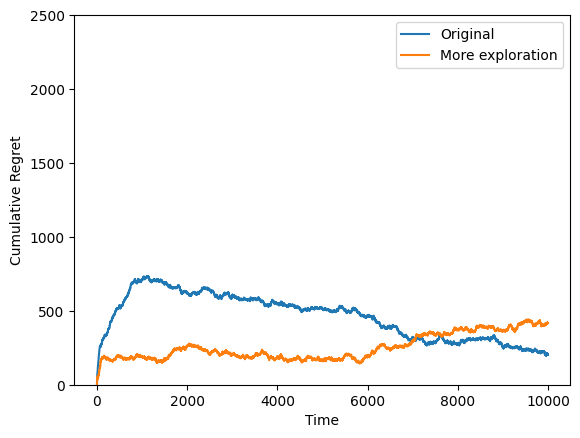

In [208]:
# plt.plot(regret_step1, label = "p = 0.5")
plt.plot(regret_step2, label = "Original")
plt.plot(regret_step3, label = "More exploration")
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.ylim(0, 2500)
plt.show()

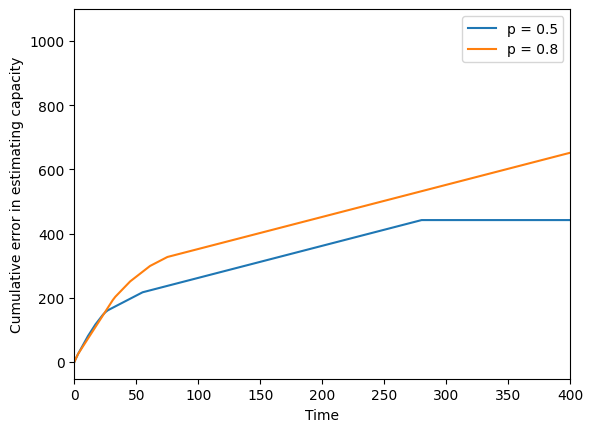

In [210]:
plt.plot(capacity_error, label = "p = 0.5")
plt.plot(capacity_error2, label = "p = 0.8")
# plt.plot(capacity_error3, label = "More exploration")
plt.xlabel("Time")
plt.ylabel("Cumulative error in estimating capacity")

# plt.ylim(0, 2000)
plt.xlim(0, 400)
plt.legend()
plt.show()

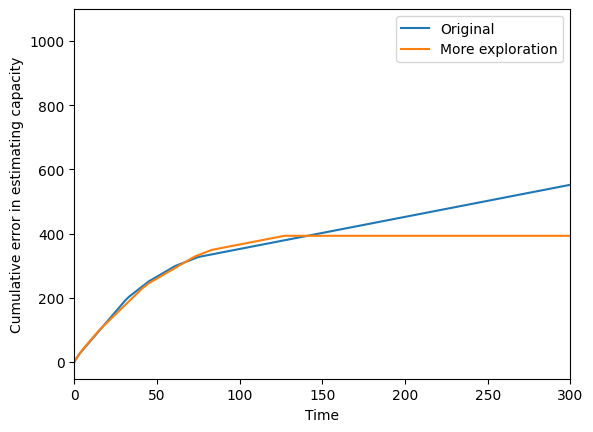

In [212]:
# plt.plot(capacity_error, label = "p = 0.5")
plt.plot(capacity_error2, label = "Original")
plt.plot(capacity_error3, label = "More exploration")
plt.xlabel("Time")
plt.ylabel("Cumulative error in estimating capacity")

# plt.ylim(0, 2000)
plt.xlim(0, 300)
plt.legend()
plt.show()

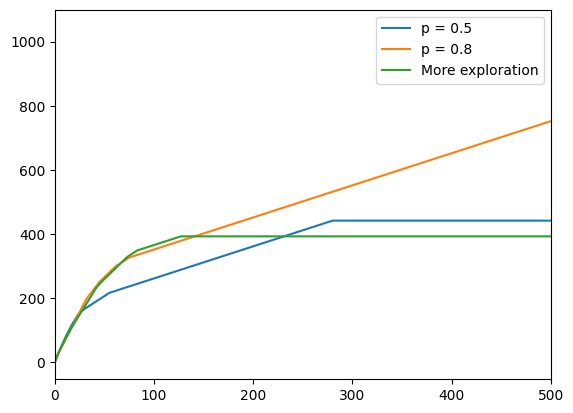

In [203]:
plt.plot(capacity_error, label = "p = 0.5")
plt.plot(capacity_error2, label = "p = 0.8")
plt.plot(capacity_error3, label = "More exploration")

# plt.ylim(0, 2000)
plt.xlim(0, 500)
plt.legend()
plt.show()

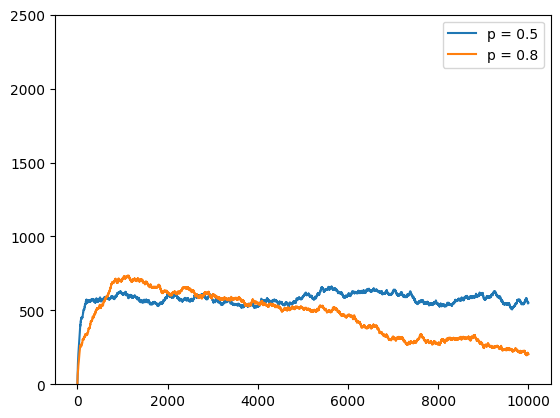

In [202]:
plt.plot(regret_step1, label='p = 0.5')
plt.plot(regret_step2, label='p = 0.8')
plt.ylim(0, 2500)
plt.legend()
plt.show()

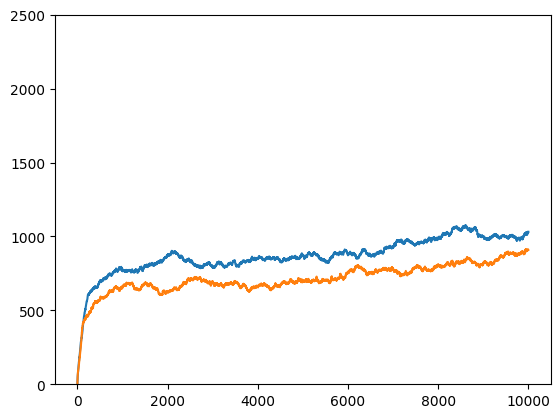

In [155]:
plt.plot(regret_step1, label='p = 0.5')
plt.plot(regret_step2, label='p = 0.8')
plt.ylim(0, 2500)
plt.show()

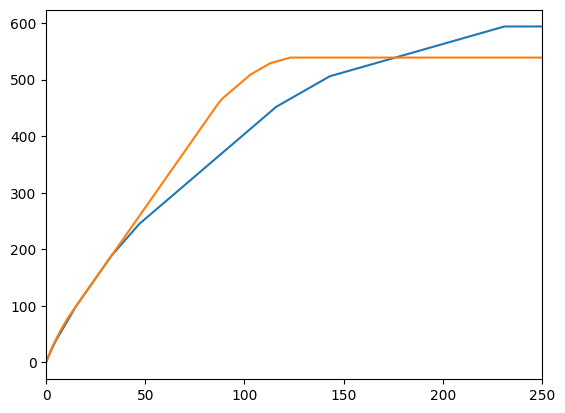

In [160]:
plt.plot(capacity_error)
plt.plot(capacity_error2)

# plt.ylim(0, 2000)
plt.xlim(0, 250)
plt.show()

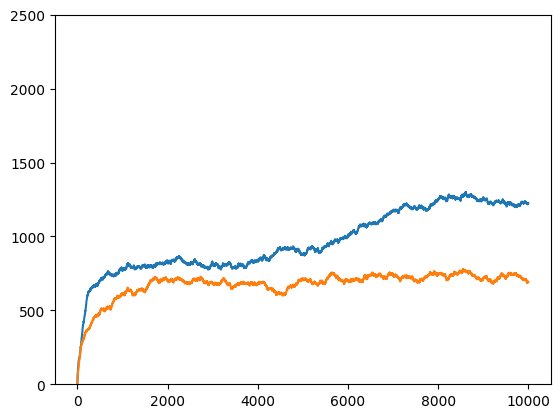

In [ ]:

plt.plot(regret_step1)
plt.plot(regret_step2)
plt.ylim(0, 2500)
plt.show()

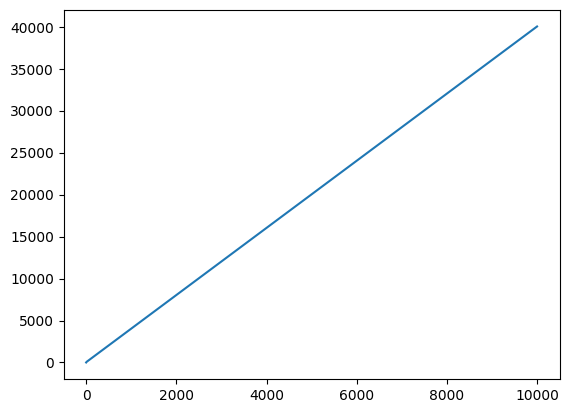

In [24]:
plt.plot(capacity_error)
# plt.ylim(0, 2000)
# plt.xlim(0, 500)
plt.show()

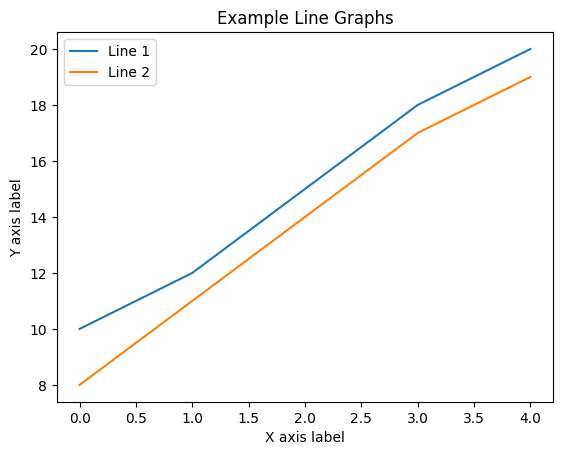

In [199]:
x = [1, 2, 3, 4, 5]
y1 = [10, 12, 15, 18, 20]
y2 = [8, 11, 14, 17, 19]

# Plot the data as line graphs
plt.plot(y1, label='Line 1')
plt.plot(y2, label='Line 2')

# Add title and axis labels
plt.title('Example Line Graphs')
plt.xlabel('X axis label')
plt.ylabel('Y axis label')

# Add legend
plt.legend()

# Display the plot
plt.show()

In [128]:
# reward = np.random.normal(mu_hat_t[1], 0.5, min(mu_hat_t[2], mu_hat_t[3]))*min(mu_hat_t[2], mu_hat_t[3])
# reward = np.random.normal(1, 0.5, 0)
# print(reward)
a = np.random.normal(5, 1, 0)
print(a)
print(sum(a))
a = [1, 1, 1, 1, 1]
idx_descending = np.argsort(a)[::-1]
print(idx_descending)

[]
0
[4 3 2 1 0]
